In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from importlib import import_module
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import math, h5py
from datetime import datetime
import tensorflow as tf

np.random.seed(1000)
ONE_HOT_LABEL = False
DECAY_STEPS = 15

# logdir = "./log/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()

Using TensorFlow backend.
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yanxiang.zyx/.local/lib/python3.6/site-pa

In [3]:
def count_data(data):
    if ONE_HOT_LABEL:
        data = data.dot(np.arange(0,5)).astype('uint8')
    unique, counts = np.unique(data, return_counts=True)
    print(dict(zip(unique, counts)))

In [4]:
# # (2) Get Data
# import tflearn.datasets.oxflower17 as oxflower17
# x, y = oxflower17.load_data(one_hot=True)

DATADIR = '/Users/yanxiang.zyx/KIPRO/associative_deep_clustering/semisup/data/npy/'

dataset_tools = import_module('tools.material')

train_images, test_images, train_labels,  test_labels = dataset_tools.get_data(one_hot=ONE_HOT_LABEL, test_size=0.2, random_state=1)

class_names = ['Cardboard', 'Pamphlet', 'Empty', 'Plastic Foil', 'Shredded Paper']

NUM_LABELS = dataset_tools.NUM_LABELS
IMAGE_SHAPE = dataset_tools.IMAGE_SHAPE

print(train_images.shape)
count_data(train_labels)
count_data(test_labels)


(400, 128, 128, 3)
{0: 84, 1: 81, 2: 84, 3: 74, 4: 77}
{0: 16, 1: 19, 2: 16, 3: 26, 4: 23}


In [5]:
# (3) Create a sequential model
model = Sequential()

# model.add(Dropout(0.5, input_shape=IMAGE_SHAPE))
# model.add(BatchNormalization(input_shape=IMAGE_SHAPE, \
#         axis=-1, momentum=0.9, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',\
#         gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None,\
#         gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=IMAGE_SHAPE, \
     kernel_size=(11,11), strides=(4,4), padding='valid', \
     trainable=False, kernel_initializer='glorot_uniform', \
     activation = 'relu'))

# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), \
#         trainable=False, \
        padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', \
         trainable=False, kernel_initializer='glorot_uniform', \
         activation = 'relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), \
#         trainable=False, \
        padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
         trainable=False, kernel_initializer='glorot_uniform', \
         activation = 'relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', \
        kernel_initializer='glorot_uniform', \
         activation = 'relu'))
# model.add(BatchNormalization(momentum=0.9))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', \
      kernel_initializer='glorot_uniform', \
      activation = 'relu'))
# model.add(BatchNormalization(momentum=0.9))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 256)       

In [6]:
def get_lr_metric(a):
    def lr(y_true, y_pred):
        return a.lr
    return lr

def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    drop = 0.95
    epochs_drop = 2.0
    if(epoch % DECAY_STEPS == 0):
        lr = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        
#     tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return lr

In [7]:
# (4) Compile 
loss_func = 'categorical_crossentropy' if ONE_HOT_LABEL else 'sparse_categorical_crossentropy'
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0001, amsgrad=False)
lrate = LearningRateScheduler(step_decay)
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])
lr_metric = get_lr_metric(adam)
model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy', lr_metric])
total_epochs = 0

In [8]:
generated_data = ImageDataGenerator(featurewise_center=False, samplewise_center=False, zoom_range=0.25,
                                            featurewise_std_normalization=False, samplewise_std_normalization=False,
                                            zca_whitening=False, rotation_range=90, horizontal_flip=False)

generated_data.fit(train_images, augment=True)

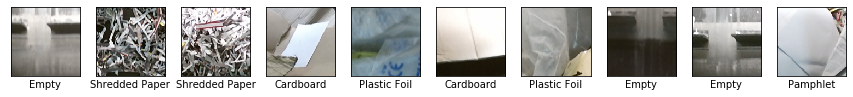

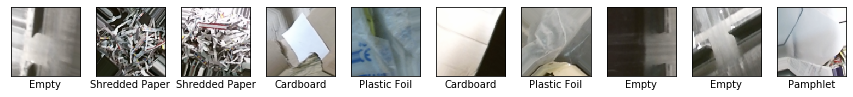

In [9]:
# plot original images
figsize=(15,15)
plt.figure(figsize=figsize)
display_num = 10
for i in range(display_num):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    class_label = np.argmax(train_labels[i]) if ONE_HOT_LABEL else train_labels[i]
    plt.xlabel(class_names[class_label])
plt.show()

# plot augmented images
plt.figure(figsize=figsize)
for X_batch, y_batch in generated_data.flow(train_images, train_labels, batch_size=16, shuffle=False):
    for i in range(display_num):
        plt.subplot(10,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = X_batch[i].astype('uint8')
        plt.imshow(image, cmap=plt.cm.binary)
        class_label = np.argmax(y_batch[i]) if ONE_HOT_LABEL else y_batch[i]
        plt.xlabel(class_names[class_label])
    plt.show()
    break


In [10]:
augmented_data = generated_data.flow(train_images, train_labels, batch_size=16)
print(len(augmented_data))

25


In [11]:
# (5) Train
print('Trained epochs:' + str(total_epochs))
r = model.fit_generator(augmented_data, validation_data=(test_images, test_labels), 
                    steps_per_epoch=100, epochs=40, shuffle=True, callbacks=[lrate])
# r = model.fit(train_images, train_labels, epochs=50, verbose=1, 
#                         validation_split=0.2, shuffle=True, batch_size=16)
total_epochs += len(r.history['loss'])




Trained epochs:0

Epoch 1/40
100/100 [==============================] - 7s 67ms/step - loss: 3.7794 - accuracy: 0.2531 - lr: 1.0000e-04 - val_loss: 1.2863 - val_accuracy: 0.4300 - val_lr: 1.0000e-04
Epoch 2/40
100/100 [==============================] - 5s 51ms/step - loss: 1.4275 - accuracy: 0.3706 - lr: 1.0000e-04 - val_loss: 1.0304 - val_accuracy: 0.5600 - val_lr: 1.0000e-04
Epoch 3/40
100/100 [==============================] - 5s 52ms/step - loss: 1.2444 - accuracy: 0.4394 - lr: 1.0000e-04 - val_loss: 1.0653 - val_accuracy: 0.5200 - val_lr: 1.0000e-04
Epoch 4/40
100/100 [==============================] - 5s 52ms/step - loss: 1.1804 - accuracy: 0.4681 - lr: 1.0000e-04 - val_loss: 1.0717 - val_accuracy: 0.5400 - val_lr: 1.0000e-04
Epoch 5/40
100/100 [==============================] - 5s 51ms/step - loss: 1.1165 - accuracy: 0.5000 - lr: 1.0000e-04 - val_loss: 0.9045 - val_accuracy: 0.6900 - val_lr: 1.0000e-04
Epoch 6/40
100/100 [==============================] - 5s 51ms/step - loss: 1.

In [12]:
test_loss, test_acc, test_lr = model.evaluate(test_images,  test_labels, verbose=1)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)
print('\nTest lr:', test_lr)

100/100 [==============================] - 0s 1ms/step

Test loss: 0.5785259366035461

Test accuracy: 0.7900000214576721

Test lr: 3.073568586842157e-05


In [ ]:
pred_images, pred_labels = train_images, train_labels

predictions = model.predict(pred_images)

pred_len = len(predictions)
count = 0
for i in range(pred_len):
    _label = np.argmax(pred_labels[i]) if ONE_HOT_LABEL else pred_labels[i]
    if _label == np.argmax(predictions[i]):
        count += 1
print(count)
print(count/pred_len)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  if ONE_HOT_LABEL:
    true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(NUM_LABELS))
  plt.yticks([])
  thisplot = plt.bar(range(NUM_LABELS), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], pred_labels, pred_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], pred_labels)
plt.tight_layout()
plt.show()